# The analysis for journey data

## An analysis for the cycle hire data

We will consider the influence of multiple factors of the physical environment on the number of travels

In [50]:
# load libraries

import os
import csv
import json
import urllib.request
from requests import get

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot

import scipy.stats
import matplotlib.pyplot as plt


In [3]:
# set path
points_path = os.path.join('data', 'cycles', 'points')
points_fn = 'BikePoints.geojson'
journeys_path = os.path.join('data', 'cycles', 'journeys')
journeys_gdf_fn = 'journeys_gdf.geoparquet'
elevation_path = os.path.join('data', 'elevation', 'london_elevation.tif')
geom_path = os.path.join('data', 'London_geometry')
lsoa_fn = 'LSOA_2011_London_gen_MHW.shp'
cc_fn = 'CentralUltraLowEmissionZone.gpkg'

In [33]:
# load data

journeys_gdf = gpd.read_parquet(os.path.join(journeys_path, journeys_gdf_fn))

## Basic analysis of the data

First, looking at the characteristics of the dataset.

In [34]:
# clean data

# convert dates into datetime format
dates = ['Start date', 'End date']
for d in dates:
    journeys_gdf[d] = pd.to_datetime(journeys_gdf[d], format = '%Y-%m-%d %H:%M')

# convert bike model into categories
journeys_gdf['Bike model'] = journeys_gdf['Bike model'].astype('category')

# remove total duration
journeys_gdf = journeys_gdf.drop('Total duration', axis = 1)

journeys_gdf.dtypes

Number                          int64
Start date             datetime64[ns]
Start station                  object
End date               datetime64[ns]
End station                    object
Bike number                     int64
Bike model                   category
Total duration (ms)             int64
start_id                       object
start_name                     object
start_ports                    object
start_location                 object
start_zone                     object
start_height                  float32
start_LSOA11CD                 object
start_LSOA11NM                 object
start_cc_zone                    bool
end_id                         object
end_name                       object
end_ports                      object
end_location                   object
end_zone                       object
end_height                    float32
end_LSOA11CD                   object
end_LSOA11NM                   object
end_cc_zone                      bool
geometry    

In [35]:
# filter by start date
journeys_gdf = journeys_gdf[journeys_gdf['Start date'] >= '2022-12-01'].copy()

In [53]:
journeys_gdf.height_diff.mean()

-0.21995632

In [57]:
journeys_gdf[journeys_gdf['Start station'] != journeys_gdf['End station']].height_diff.mean()

-0.22877766

In [51]:
scipy.stats.ttest_1samp(journeys_gdf.height_diff, popmean = 0)

TtestResult(statistic=-69.61426590290411, pvalue=0.0, df=8414630)

### The average height difference

The average of the height difference is -0.22 m. From the one sample T-test, the null hypothesis of average being 0 is rejected, and is statistically significant, concluding that on average the shared cycles are used more downhill than uphill.

(array([1.443276e+06, 2.202603e+06, 1.763172e+06, 1.216677e+06,
        7.556930e+05, 4.513590e+05, 2.545110e+05, 1.445900e+05,
        8.518200e+04, 4.782000e+04, 2.491700e+04, 1.258100e+04,
        6.461000e+03, 2.777000e+03, 1.500000e+03, 9.490000e+02,
        3.900000e+02, 1.320000e+02, 3.600000e+01, 5.000000e+00]),
 array([    0.        ,   858.53878817,  1717.07757635,  2575.61636452,
         3434.15515269,  4292.69394087,  5151.23272904,  6009.77151721,
         6868.31030539,  7726.84909356,  8585.38788174,  9443.92666991,
        10302.46545808, 11161.00424626, 12019.54303443, 12878.0818226 ,
        13736.62061078, 14595.15939895, 15453.69818712, 16312.2369753 ,
        17170.77576347]),
 <BarContainer object of 20 artists>)

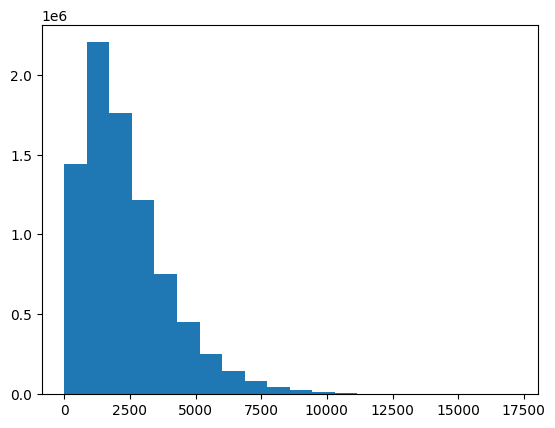

In [56]:
# draw scatter plot

plt.hist(journeys_gdf['distance'], bins = 20)


In [ ]:
# calculate average speed
journeys_gdf['ave_speed'] = journeys_gdf['distance'] / journeys_gdf['Total duration (ms)'] * 1000

In [ ]:
journeys_gdf.sort_values(by = ['ave_speed'], ascending = False).head(10)

,Number,Start date,Start station,End date,End station,Bike number,Bike model,Total duration (ms),start_id,start_name,...,end_location,end_zone,end_height,end_LSOA11CD,end_LSOA11NM,end_cc_zone,geometry,height_diff,distance,ave_speed
7365150,134763170,2023-10-10 08:02:00,"Royal Avenue 2, Chelsea",2023-10-10 08:02:00,"Wellington Arch, Hyde Park",56185,CLASSIC,907,003462,"Royal Avenue 2, Chelsea",...,Wellington Arch,Hyde Park,14.571250,E01004736,Westminster 018C,True,"LINESTRING (527674.761 178393.495, 528531.182 ...",7.434500,1666.815864,1837.724216
5607750,132913193,2023-08-04 09:03:00,"Tanner Street, Bermondsey",2023-08-04 09:03:00,"Snow Hill, Farringdon",54561,CLASSIC,5645,000994,"Tanner Street, Bermondsey",...,Snow Hill,Farringdon,13.625750,E01032740,City of London 001G,True,"LINESTRING (533462.695 179717.629, 531679.205 ...",10.554749,2541.325927,450.190598
4369319,131763942,2023-06-23 16:00:00,"Saltoun Road, Brixton",2023-06-23 16:00:00,"New Road 1 , Whitechapel",61132,PBSC_EBIKE,17681,300206,"Saltoun Road, Brixton",...,New Road 1,Whitechapel,13.506250,E01004322,Tower Hamlets 017A,False,"LINESTRING (531026.004 175157.008, 534514.907 ...",-3.412748,7409.370131,419.058319
6951719,134065628,2023-09-15 19:35:00,"Queen's Circus, Battersea Park",2023-09-15 19:35:00,"Orbel Street, Battersea",58216,CLASSIC,4276,200190,"Queen's Circus, Battersea Park",...,Orbel Street,Battersea,4.074000,E01004579,Wandsworth 004B,False,"LINESTRING (528603.043 177029.956, 527177.036 ...",-0.242500,1475.513299,345.068592
568913,127768960,2023-01-06 10:58:00,"Preston's Road, Cubitt Town",2023-01-06 10:58:00,"Upper Bank Street, Canary Wharf",22661,CLASSIC,2377,200232,"Preston's Road, Cubitt Town",...,Upper Bank Street,Canary Wharf,9.438751,E01032771,Tower Hamlets 033B,False,"LINESTRING (538286.831 179695.102, 537683.774 ...",7.193501,727.087330,305.884447
8256196,135751631,2023-11-21 17:09:00,"Flood Street, Chelsea",2023-11-21 17:09:00,"Bourne Street, Belgravia",52867,CLASSIC,3296,001218,"Flood Street, Chelsea",...,Bourne Street,Belgravia,7.111250,E01004666,Westminster 023B,False,"LINESTRING (527370.876 178156.653, 528309.943 ...",-0.125500,1002.276788,304.088831
5637053,132900027,2023-08-03 18:21:00,"Sutton Street, Shadwell",2023-08-03 18:21:00,"St. Mary Axe, Aldgate",60432,PBSC_EBIKE,7045,200256,"Sutton Street, Shadwell",...,St. Mary Axe,Aldgate,15.499000,E01032739,City of London 001F,True,"LINESTRING (535169.920 180922.169, 533280.123 ...",4.200749,1913.715335,271.641637
6251174,133732053,2023-09-05 08:20:00,"Archbishop's Park, Waterloo",2023-09-05 08:20:00,"Wellington Arch, Hyde Park",60300,PBSC_EBIKE,8530,300025,"Archbishop's Park, Waterloo",...,Wellington Arch,Hyde Park,14.571250,E01004736,Westminster 018C,True,"LINESTRING (530770.060 179379.928, 528531.182 ...",9.632000,2282.389913,267.572088
7930626,135551682,2023-11-12 20:45:00,"Milroy Walk, South Bank",2023-11-12 20:45:00,"Cranmer Road, Stockwell",51315,CLASSIC,12999,000959,"Milroy Walk, South Bank",...,Cranmer Road,Stockwell,5.713250,E01003183,Lambeth 005E,False,"LINESTRING (531525.563 180401.245, 531241.653 ...",0.740250,3096.411703,238.203839
6251139,133732611,2023-09-05 08:28:00,"Chelsea Green, Chelsea",2023-09-05 08:28:00,"Wellington Arch, Hyde Park",55360,CLASSIC,7717,001179,"Chelsea Green, Chelsea",...,Wellington Arch,Hyde Park,14.571250,E01004736,Westminster 018C,True,"LINESTRING (527390.804 178451.025, 528531.182 ...",7.836000,1784.392438,231.228773
